In [9]:
!pip install datasets;
!pip install -U sentence-transformers;

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import torch

In [8]:
# Load dataset
train_set = load_dataset("BENBENBENb/sythetic_casual_relation_medium_scale", split = 'train');

# Load the sentence transformer model for embedding generation
model = SentenceTransformer('all-MiniLM-L6-v2');

# Filter the dataset based on political leaning into two subsets: left and right
train_set_left = train_set.filter(lambda x: x['political_leaning'] == 'LEFT');
train_set_right = train_set.filter(lambda x: x['political_leaning'] == 'RIGHT');

# Trial 1: Subtraction
Here  we are view causal relations as embedding of effect - embedding of cause. Subtracting the embedding of the cause from the effect to obtain the embedding of causal relations is an intuitive approach, based on the assumption that the resulting vector would capture the transformation from the cause to the effect. However, this may not always be the most effective method. One issue with this approach is that it assumes linear separability and uniform distribution of the causal and effect spaces, which may not be true in a high-dimensional embedding space.

In [6]:
def extract_causal_relation_embeddings_with_text_by_subtraction(dataset):
    """
    Extracts and computes embeddings for causal relations in a given dataset.

    Args:
    dataset (dict): A dictionary containing the dataset with a key 'GPT_causal_graph' for causal pairs.

    Returns:
    tuple: A tuple containing the relation embeddings as a NumPy array and the list of text pairs.
    """

    # Simplified extraction and transformation of causal pairs
    causal_pairs = [pair.split('\n') for pair in dataset['GPT_causal_graph']]
    flattened_pairs = [pair for sublist in causal_pairs for pair in sublist]
    cause_effect_pairs = [tuple(pair.split('->')) for pair in flattened_pairs]

    # Separating causes and effects with error handling
    causes, effects = zip(*[(p[0], p[1] if len(p) > 1 else '') for p in cause_effect_pairs])

    # Embedding calculations
    try:
        cause_embeddings = model.encode(causes, convert_to_tensor=True)
        effect_embeddings = model.encode(effects, convert_to_tensor=True)
    except Exception as e:
        raise RuntimeError("Error in embedding calculation: " + str(e))

    # Computing relation embeddings
    relation_embeddings = effect_embeddings - cause_embeddings

    return relation_embeddings.cpu().numpy(), cause_effect_pairs


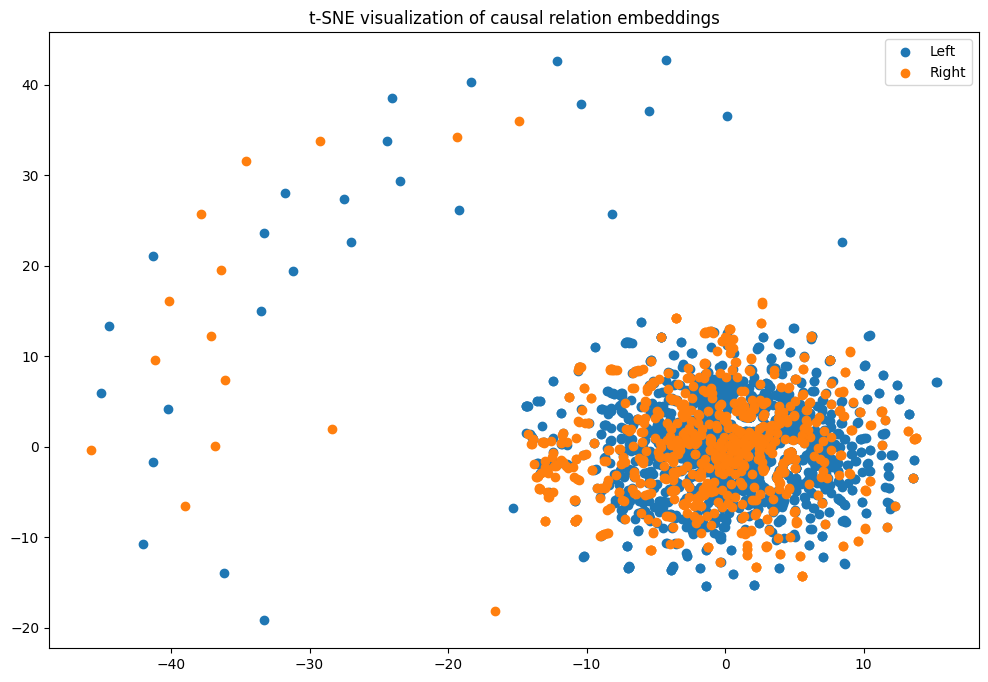

In [7]:
# Step 1: Obtain causal relation embeddings for both left and right subsets
embeddings_left_subtraction, text_pairs_left_subtraction = extract_causal_relation_embeddings_with_text_by_subtraction(train_set_left)
embeddings_right_subtraction, text_pairs_right_subtraction = extract_causal_relation_embeddings_with_text_by_subtraction(train_set_right)

# Step 2: Combine embeddings from both subsets and create corresponding labels for visualization
combined_embeddings_subtraction = np.vstack((embeddings_left_subtraction, embeddings_right_subtraction))
labels_subtraction = ['Left'] * len(embeddings_left_subtraction) + ['Right'] * len(embeddings_right_subtraction)

# Step 3: Apply t-SNE for dimensionality reduction to visualize the embeddings
tsne_subtraction = TSNE(n_components=2, random_state=0)
reduced_embeddings_subtraction = tsne_subtraction.fit_transform(combined_embeddings_subtraction)

# Plotting the results using matplotlib
plt.figure(figsize=(12, 8))
for i, label in enumerate(set(labels_subtraction)):
    indices = [j for j, l in enumerate(labels_subtraction) if l == label]
    plt.scatter(reduced_embeddings_subtraction[indices, 0], reduced_embeddings_subtraction[indices, 1], label=label)
plt.legend()
plt.title('t-SNE visualization of causal relation embeddings')
plt.show()

The t-SNE plot indicates that there is significant overlap between the embeddings of causal relations from left-wing and right-wing media. This suggests that the distinction between the two in terms of causal language or framing may not be as clear-cut as hypothesized, or that the embeddings are not capturing the nuances that differentiate the political leanings. The clustering is not distinctly separable, which might indicate that causal relations, as captured by the embeddings, do not vary greatly between the two media leanings, at least not in a way that is captured by the current model and method.

# Trial 2: Interaction Terms
Here we try to concatenate the embedding of cause with embedding of effect to capture the causal relations.

This approach allows for the individual properties of the cause and effect to be maintained separately within the embedding space, which can be beneficial if the distinction between cause and effect is important for downstream tasks.

The concatenation increases the dimensionality of the feature space, which could potentially capture a richer representation of the causal relationship.

It can be useful when the model needs to learn complex interactions between the cause and effect that are not necessarily linear or additive.

In [10]:
def extract_causal_relation_embeddings_with_text_by_interaction_terms(dataset):
    causal_pairs = [pair.split('\n') for pair in dataset['GPT_causal_graph']]
    flattened_pairs = [pair for sublist in causal_pairs for pair in sublist]
    cause_effect_pairs = [tuple(pair.split('->')) for pair in flattened_pairs]
    causes, effects = zip(*[(p[0], p[1] if len(p) > 1 else '') for p in cause_effect_pairs])

    try:
        cause_embeddings = model.encode(causes, convert_to_tensor=True)
        effect_embeddings = model.encode(effects, convert_to_tensor=True)
        # Concatenating cause and effect embeddings
        relation_embeddings = torch.cat((cause_embeddings, effect_embeddings), dim=1)
    except Exception as e:
        raise RuntimeError("Error in embedding calculation: " + str(e))

    return relation_embeddings.cpu().numpy(), cause_effect_pairs

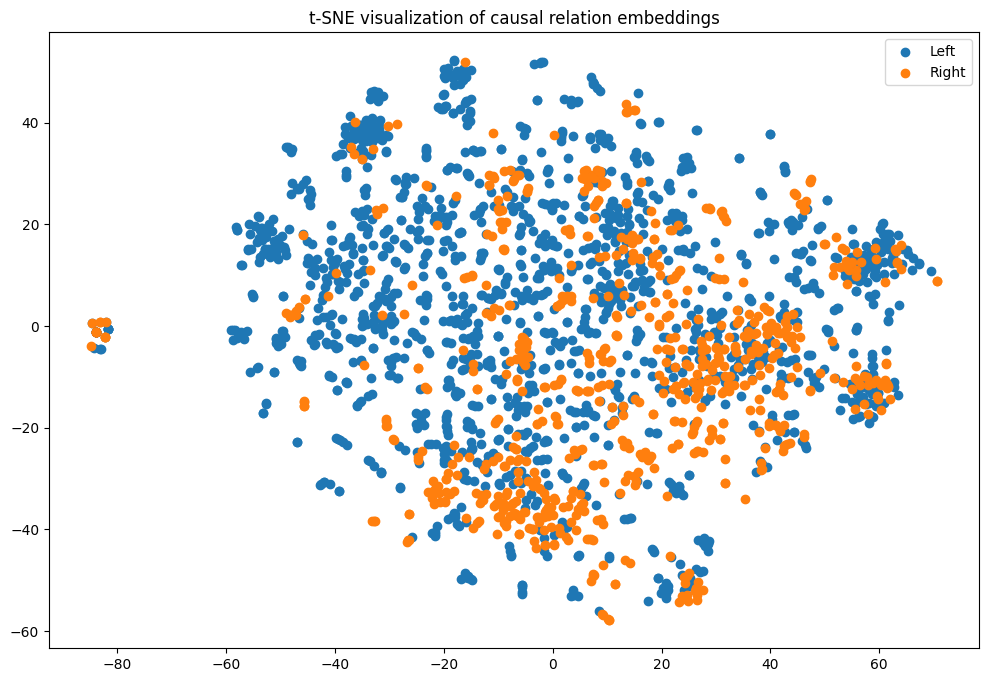

In [11]:
# Step 1: Obtain causal relation embeddings for both left and right subsets
embeddings_left_interaction, text_pairs_left_interaction = extract_causal_relation_embeddings_with_text_by_interaction_terms(train_set_left)
embeddings_right_interaction, text_pairs_right_interaction = extract_causal_relation_embeddings_with_text_by_interaction_terms(train_set_right)

# Step 2: Combine embeddings from both subsets and create corresponding labels for visualization
combined_embeddings_interaction = np.vstack((embeddings_left_interaction, embeddings_right_interaction))
labels_interaction = ['Left'] * len(embeddings_left_interaction) + ['Right'] * len(embeddings_right_interaction)

# Step 3: Apply t-SNE for dimensionality reduction to visualize the embeddings
tsne_interaction = TSNE(n_components=2, random_state=0)
reduced_embeddings_interaction = tsne_interaction.fit_transform(combined_embeddings_interaction)

# Plotting the results using matplotlib
plt.figure(figsize=(12, 8))
for i, label in enumerate(set(labels_interaction)):
    indices = [j for j, l in enumerate(labels_interaction) if l == label]
    plt.scatter(reduced_embeddings_interaction[indices, 0], reduced_embeddings_interaction[indices, 1], label=label)
plt.legend()
plt.title('t-SNE visualization of causal relation embeddings')
plt.show()

Given the overlap, it's not immediately clear if there are distinct common causal topics for each political leaning.

# Trial 3: Direct Embedding of the Entire Causal Relation Sentence
Embedding the entire causal relation as a single sentence might allow the model to capture the context and the interplay between the cause and effect in a more natural and holistic way.

It can be more computationally efficient since it generates a single embedding vector for the entire causal relation, as opposed to a larger concatenated vector from separate embeddings.

This approach assumes that the language model is capable of understanding and encoding the causal relation within the structure of the sentence, which may or may not be the case depending on the sophistication of the model and the complexity of the causal relation.

In [12]:
def extract_causal_relation_embeddings_with_text_by_direct_embedding(dataset):
    causal_sentences = [' -> '.join(pair.split('\n')) for pair in dataset['GPT_causal_graph']]
    try:
        # Direct embedding of the entire causal relation
        relation_embeddings = model.encode(causal_sentences, convert_to_tensor=True)
    except Exception as e:
        raise RuntimeError("Error in embedding calculation: " + str(e))

    return relation_embeddings.cpu().numpy(), causal_sentences

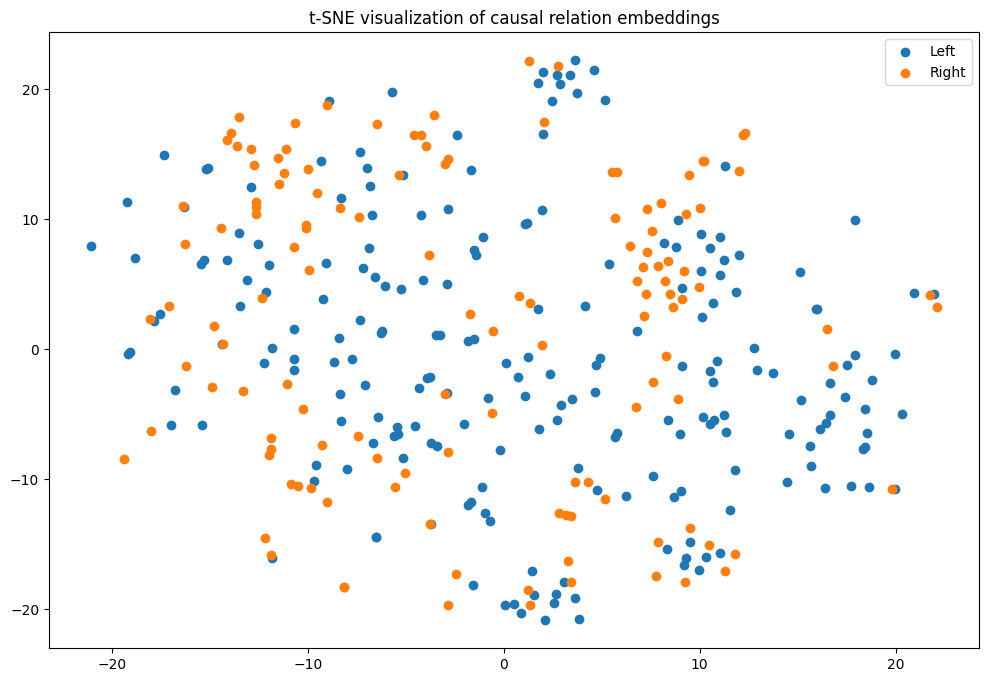

In [13]:
# Step 1: Obtain causal relation embeddings for both left and right subsets
embeddings_left_direct, text_pairs_left_direct = extract_causal_relation_embeddings_with_text_by_direct_embedding(train_set_left)
embeddings_right_direct, text_pairs_right_direct = extract_causal_relation_embeddings_with_text_by_direct_embedding(train_set_right)

# Step 2: Combine embeddings from both subsets and create corresponding labels for visualization
combined_embeddings_direct = np.vstack((embeddings_left_direct, embeddings_right_direct))
labels_direct = ['Left'] * len(embeddings_left_direct) + ['Right'] * len(embeddings_right_direct)

# Step 3: Apply t-SNE for dimensionality reduction to visualize the embeddings
tsne_direct = TSNE(n_components=2, random_state=0)
reduced_embeddings_direct = tsne_direct.fit_transform(combined_embeddings_direct)

# Plotting the results using matplotlib
plt.figure(figsize=(12, 8))
for i, label in enumerate(set(labels_direct)):
    indices = [j for j, l in enumerate(labels_direct) if l == label]
    plt.scatter(reduced_embeddings_direct[indices, 0], reduced_embeddings_direct[indices, 1], label=label)
plt.legend()
plt.title('t-SNE visualization of causal relation embeddings')
plt.show()

Samilar results with previous 2 trials. The t-SNE plot of causal relation embeddings shows both left-wing (blue) and right-wing (orange) media are intermixed throughout the space. The lack of clear clustering suggests that the causal relations from both political leanings are not distinctly separable in the embedding space created by the model.But we can do some furthur analysis.

### Shared Topics:
The areas of high density suggest that there are common causal topics or language patterns that both left-wing and right-wing media sources discuss. This could imply that certain issues or events are universally newsworthy, leading to similar causal discussions across the political spectrum.

### Subtle Differences:
While the clusters are not distinctly separated, there might be subtle differences within these dense areas that are not immediately visible on the t-SNE plot. For instance, even within a cluster, there might be a tendency for left-wing and right-wing points to form subclusters or to be located in specific regions of a dense area.

### Analysis of Topics:
To ascertain whether different common causal topics exist, we may need to analyze the textual data corresponding to the embeddings in the high-density areas. By examining the most common words, phrases, or topics associated with these points, we could potentially identify themes that are more prevalent in one political leaning versus the other.

### High-Dimensional Nuances:
t-SNE reduces the dimensionality of the data to two dimensions for visualization purposes, which can sometimes merge distinct clusters that are separable in higher dimensions. It is possible that in the original high-dimensional space, there are nuances that separate the causal topics of left-wing and right-wing media to some extent.

# Trial 4: Analyze the common topics for each political leaning (using direct embedding)

To analyze the common topics for each political leaning, we can perform text analysis on the most densely populated areas of the t-SNE plot. Below is a step-by-step approach:

1. Identify High-Density Areas: use clustering algorithms like DBSCAN or K-Means on the t-SNE results to identify clusters.

2. Extract Representative Text: Once we have identified clusters, we can extract the textual data (causal sentences) corresponding to the embeddings in these clusters.

3. Text Analysis:
    - Frequency Analysis: Count the frequency of words and phrases in the causal sentences of each cluster to identify common topics.
    - Topic Modeling: Use algorithms like Latent Dirichlet Allocation (LDA) to discover topics within the causal sentences.
    - Comparison: Compare the most frequent terms and derived topics between the clusters associated with the left and right political leanings.

4. Comparison

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top words in left-wing cluster 0: [('trump', 170), ('iran', 150), ('government', 136), ('new', 109), ('protests', 106)]
Top words in left-wing cluster 2: [('korea', 100), ('north', 87), ('south', 48), ('kim', 36), ('nuclear', 35)]
Top words in left-wing cluster 3: [('pakistan', 100), ('trump', 71), ('president', 33), ('aid', 25), ('us', 22)]
Top words in left-wing cluster 4: [('marijuana', 61), ('california', 29), ('state', 21), ('legalization', 18), ('new', 18)]
Top words in right-wing cluster 1: [('temperatures', 13), ('warming', 13), ('arctic', 12), ('global', 10), ('climate', 8)]
Top words in right-wing cluster 5: [('lorde', 13), ('israel', 11), ('bds', 9), ('boteach', 6), ('new', 6)]
Top words in right-wing cluster 6: [('melania', 4), ('dress', 3), ('party', 3), ('trump', 3), ('wearing', 3)]
Top words in right-wing cluster 7: [('alcohol', 3), ('attacks', 3), ('copts', 3), ('store', 3), ('attack', 2)]


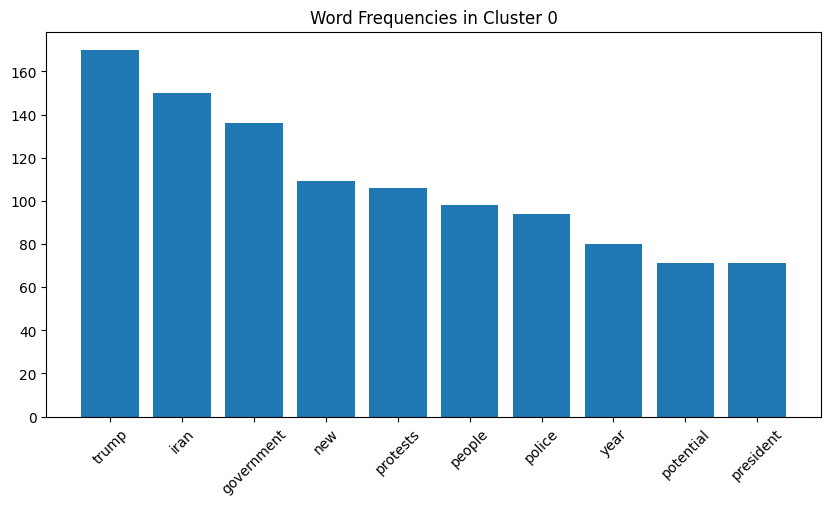

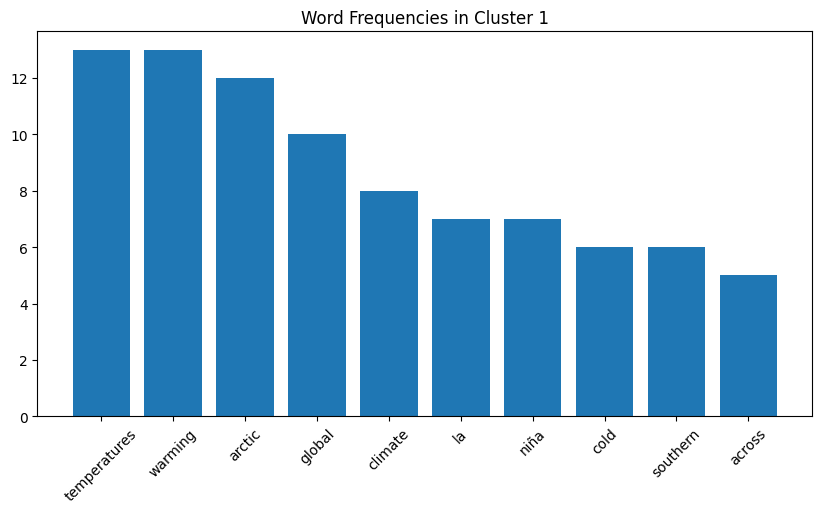

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Step 1: Identify high-density areas using DBSCAN
db = DBSCAN(eps=3, min_samples=2).fit(reduced_embeddings_direct)
labels = db.labels_

# Filter out noise (-1 label)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Step 2: Extract representative text for each cluster
cluster_texts = {}
for cluster_id in set(labels):
    if cluster_id != -1:  # Ignore noise
        indices = [i for i, label in enumerate(labels) if label == cluster_id]
        cluster_texts[cluster_id] = [text_pairs_left_direct[i] if 'Left' in labels_direct[i] else text_pairs_right_direct[i-len(embeddings_left_direct)] for i in indices]

# Step 3: Text analysis
nltk.download('stopwords')
exclude_words = {'effect', 'cause', 'the', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'s", "'", "``", "''", "’"}
stop_words = set(stopwords.words('english')) | exclude_words

# Convert stop_words set to a list before using it in CountVectorizer
stop_words_list = list(stop_words)


def perform_text_analysis(texts):
    # Frequency Analysis
    vectorizer = CountVectorizer(stop_words=stop_words_list)
    X = vectorizer.fit_transform(texts)
    word_freq = np.asarray(X.sum(axis=0)).ravel().tolist()
    words = vectorizer.get_feature_names_out()
    freq_distribution = dict(zip(words, word_freq))

    # Topic Modeling
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(X)
    topics = lda.components_

    return freq_distribution, topics

# Analyze text for each cluster
cluster_analysis_results = {}
for cluster_id, texts in cluster_texts.items():
    freq_distribution, topics = perform_text_analysis(texts)
    cluster_analysis_results[cluster_id] = {
        'frequency': freq_distribution,
        'topics': topics
    }

# Step 4: Comparison
# Compare the results from cluster_analysis_results for clusters corresponding to left and right-wing texts

# Determine predominant political leaning in each cluster
cluster_leanings = {}
for cluster_id in cluster_texts:
    left_count = sum(1 for text in cluster_texts[cluster_id] if text in text_pairs_left_direct)
    right_count = sum(1 for text in cluster_texts[cluster_id] if text in text_pairs_right_direct)
    cluster_leanings[cluster_id] = 'Left' if left_count > right_count else 'Right'

# Compare frequency distributions
left_freq_distributions = {cluster_id: cluster_analysis_results[cluster_id]['frequency']
                           for cluster_id in cluster_leanings if cluster_leanings[cluster_id] == 'Left'}
right_freq_distributions = {cluster_id: cluster_analysis_results[cluster_id]['frequency']
                            for cluster_id in cluster_leanings if cluster_leanings[cluster_id] == 'Right'}

# Example: print top 5 words in each cluster
for cluster_id in left_freq_distributions:
    print(f"Top words in left-wing cluster {cluster_id}: {sorted(left_freq_distributions[cluster_id].items(), key=lambda x: x[1], reverse=True)[:5]}")
for cluster_id in right_freq_distributions:
    print(f"Top words in right-wing cluster {cluster_id}: {sorted(right_freq_distributions[cluster_id].items(), key=lambda x: x[1], reverse=True)[:5]}")

# Compare topics
left_topics = {cluster_id: cluster_analysis_results[cluster_id]['topics']
               for cluster_id in cluster_leanings if cluster_leanings[cluster_id] == 'Left'}
right_topics = {cluster_id: cluster_analysis_results[cluster_id]['topics']
                for cluster_id in cluster_leanings if cluster_leanings[cluster_id] == 'Right'}

# Example: print topics for each cluster
# for cluster_id in left_topics:
#     print(f"Topics in left-wing cluster {cluster_id}: {left_topics[cluster_id]}")
# for cluster_id in right_topics:
#     print(f"Topics in right-wing cluster {cluster_id}: {right_topics[cluster_id]}")

# Visualization example using matplotlib
def plot_word_frequencies(cluster_id, freq_distribution):
    words, frequencies = zip(*sorted(freq_distribution.items(), key=lambda x: x[1], reverse=True)[:10])
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.title(f'Word Frequencies in Cluster {cluster_id}')
    plt.xticks(rotation=45)
    plt.show()

# Plot for one left-wing and one right-wing cluster as an example
plot_word_frequencies(next(iter(left_freq_distributions)), left_freq_distributions[next(iter(left_freq_distributions))])
plot_word_frequencies(next(iter(right_freq_distributions)), right_freq_distributions[next(iter(right_freq_distributions))])

# Trial 5: Get typical causal relations

In this section, we want to get some typical embdeedings from left-wing and right-wing media (using subtraction embeddings). The process involves:

1. **Calculating Mean Embeddings**: We compute the average embedding for each set of embeddings, which helps in identifying the central theme or common features in the texts from each source.

2. **Finding Closest Text Pairs**: Using a custom function, we identify text pairs that are closest to these mean embeddings. This is achieved by computing the cosine distance between each text pair's embedding and the mean embedding. The closest pairs are indicative of the most representative or recurring themes in the texts from each media source.

3. **Comparison and Display**: The final step involves printing the closest text pairs for both media types. This comparative analysis helps in understanding the differences or similarities in narrative or content focus between left-wing and right-wing media.




In [25]:
# Function to calculate mean embedding
def mean_embedding(embeddings):
    return np.mean(embeddings, axis=0)

# Compute mean embeddings
mean_left_embedding = mean_embedding(embeddings_left_subtraction)
mean_right_embedding = mean_embedding(embeddings_right_subtraction)


# Find closest examples to mean embeddings
def closest_text_pairs(mean_embedding, embeddings, text_pairs, num_examples=10):
    distances = [cosine(mean_embedding, emb) for emb in embeddings]
    closest_indices = np.argsort(distances)[:num_examples]

    # Filter out tuples that don't have two elements
    filtered_text_pairs = [pair for pair in text_pairs if len(pair) == 2]

    # Find closest pairs within the filtered list
    return [filtered_text_pairs[i] for i in closest_indices if i < len(filtered_text_pairs)]

closest_left = closest_text_pairs(mean_left_embedding, embeddings_left_subtraction, text_pairs_left_subtraction)
closest_right = closest_text_pairs(mean_right_embedding, embeddings_right_subtraction, text_pairs_right_subtraction)

# Print results
print("Closest causal relations to average in left-wing media:")
for pair in closest_left:
    print(f"{pair[0]} -> {pair[1]}")

print("\nClosest causal relations to average in right-wing media:")
for pair in closest_right:
    print(f"{pair[0]} -> {pair[1]}")

print("\nClosest causal relations to average in right-wing media:")

Closest causal relations to average in left-wing media:
4. [cause] Visiting the Western Wall  ->  [effect] Understanding that Israel is a place of peace for people like Shimshon.
6. [cause] Traditional homeless hostels being unsafe and expensive for working homeless people  ->  [effect] Maria Marsden sets up Stop Start Go as alternative accommodation
4. [cause] Cuts to in-work benefits and increased cost of housing and living  ->  [effect] Increase in working homeless people
2. [cause] Homeless workers tend to lose jobs two weeks after becoming homeless  ->  [effect] The creation of dedicated bedsits at Stop Start Go for those with jobs 
8. [cause] China's growing power  ->  [effect] Necessity to learn value of forbearance
11. [cause] Risk of a weakened Iran  ->  [effect] Possibility of a more volatile and unpredictable Iran, further straining its relationships with other nations.
4. [cause] Researchers 'threaten' the masculinity of male participants  ->  [effect] Men are more likely t

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
